# 07. 최솟값, 최댓값, 혼합분포

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

In [2]:
from utils import set_pyplot_params
set_pyplot_params()

<br>

## 07.01. 누적분포함수

'유로문제'에서의 사후확률분포

In [3]:
import numpy as np
from empiricaldist import Pmf

In [4]:
hypos = np.linspace(0, 1, 101)
pmf = Pmf(1, hypos)
data = 140, 250

In [5]:
from scipy.stats import binom

In [6]:
def update_binomial(pmf, data):

    """이항분포를 사용한 pmf 갱신"""
    k, n = data
    xs = pmf.qs
    likelihood = binom.pmf(k, n, xs)
    pmf *= likelihood
    pmf.normalize()

In [7]:
update_binomial(pmf, data)

**CDF는 PMF의 누적합**

In [23]:
cumulative = pmf.cumsum()
cumulative.head()

0.00     0.000000e+00
0.01    1.256330e-207
0.02    5.731921e-166
0.03    8.338711e-142
0.04    8.269265e-125
Name: , dtype: float64

In [11]:
from utils import decorate

In [14]:
def decorate_euro(title):
    decorate(xlabel='Proportion of heads (x)', ylabel='Probability', title=title)

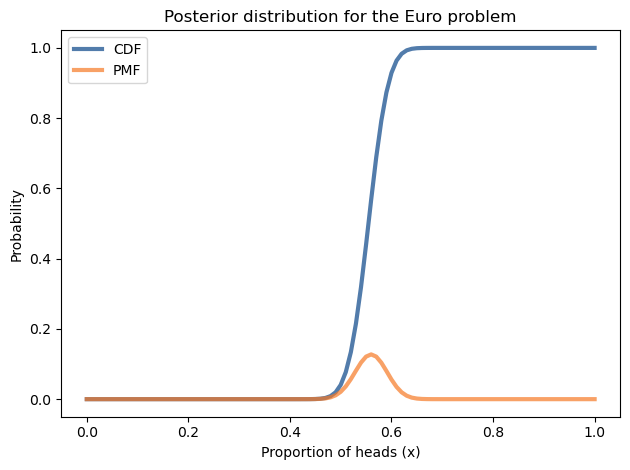

In [15]:
cumulative.plot(label='CDF')
pmf.plot(label='PMF')
decorate_euro(title='Posterior distribution for the Euro problem')

**CDF는 0과 1사이의 값을 가짐**

<br>

- **0.61과 같거나 이보다 작은 값에 대한 총 확률이 96%**

In [17]:
cumulative[0.61]

0.9638303193984252

<br>

**확률과 이에 대응하는 값을 연결시키는 보간법**
- 이 누적분포함수의 96분위에 해당하는 값이 0.61

In [18]:
from scipy.interpolate import interp1d

In [24]:
ps = cumulative.values
qs = cumulative.index

interp = interp1d(ps, qs)
interp(0.96)

array(0.60890171)

<br>

#### `empiricaldist`라이브러리에서 누적분포함수를 나타내는 클래스인 `Cdf` 사용가능
#### `Pmf`를 가지고 `Cdf`를 계산

<br>

#### `Pmf객체.make_cdf()`

In [28]:
cdf = pmf.make_cdf()

In [29]:
cdf[0.61]

0.9638303193984252

- 이 분포에 들어있지 않은 수를 호출하면 KeyError 발생

In [30]:
try:
    cdf[0.615]
except KeyError as e:
    print(repr(e))

KeyError(0.615)


- `make_cdf()`메소드로 생성한 `Cdf`객체를 함수로 호출하여 사용

In [31]:
cdf(0.615)

array(0.96383032)

- CDF의 96분위수

In [32]:
cdf.quantile(0.9638303)

array(0.61)

- **주어진 확률에 대한 신용구간계산**

#### `Cdf객체.credible_interval()`

In [33]:
cdf.credible_interval(0.9)

array([0.51, 0.61])

- `Cdf`객체에서 역으로 확률질량함수 `Pmf`객체 생성

#### `Cdf객체.make_pmf()`

In [18]:
pmf = cdf.make_pmf()

<br>

## 07.02. 넷 중 높은 값

게임에서 새로운 캐릭터를 만들기 위하여, 플레이어는 각 능력치에 대해 육면체 주사위 4개를 굴린 후, 이 중 세 개의 높은 값을 더함
    - 주사위 4개를 굴려서 1, 2, 3, 4가 나왔다면 $\rightarrow$ 능력치는 2 + 3 + 4 = 9


In [42]:
from utils import make_die
from utils import add_dist_seq

- **주사위 3개 합의 분포**

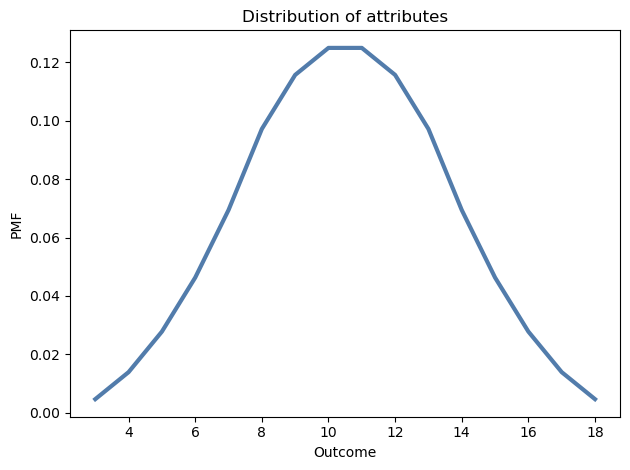

In [41]:
die = make_die(6)
dice = [die] * 3

pmf_3d6 = add_dist_seq(dice)

def decorate_dice(title=''):
    decorate(xlabel='Outcome', ylabel='PMF', title=title)
    
pmf_3d6.plot()
decorate_dice('Distribution of attributes')

<br>

**만약 주사위 4개를 굴려서 이 중 높은 값 3개를 더할 때**
- 10000개 주사위에 대해 시뮬레이션 한 후 분포 추정

<br>

- **1 ~ 6사이의 n=4 크기의 복원 추출을 10000번 시행**

In [48]:
n = 10000
a = np.random.randint(1, 7, size=(n, 4))

- **각 행 (각 시행)에서 세 개의 높은 값을 정렬하고, 세 개의 높은 값을 더함 (t)**

In [51]:
a.sort(axis=1)
t = a[:, 1:].sum(axis=1)

- **t의 PMF**

In [53]:
pmf_best3 = Pmf.from_seq(t)

<br>

#### 3개 주사위 값 합에 대한 분포 vs 4개 주사위의 값 중 높은 3개의 합에 대한 분포 (Best 3 of 4)

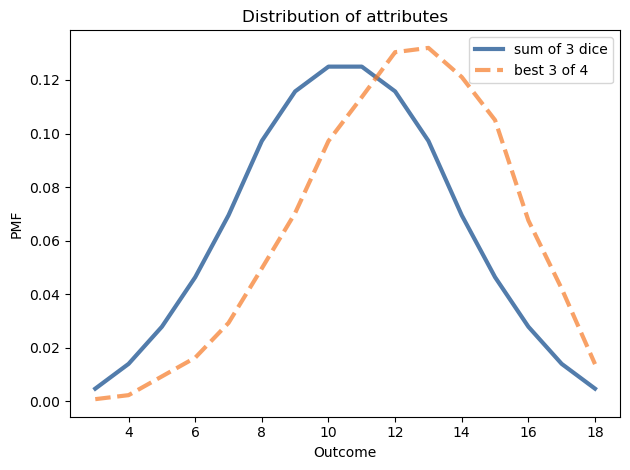

In [54]:
pmf_3d6.plot(label='sum of 3 dice')
pmf_best3.plot(label='best 3 of 4', ls='--')

decorate_dice('Distribution of attributes')

## 07.03. 최댓값

- 4개 주사위의 값 중 높은 3개의 합에 대한 분포 (Best 3 of 4)의 누적분포함수

In [55]:
cdf_best3 = pmf_best3.make_cdf()

- **누적분포함수값 (`Cdf(x)`)은 $x$보다 같거나 작은 값에 대한 확률의 합**

    **따라서, 이 분포에서 6개의 값을 골랐을 때, 모든 6개의 값이 $x$보다 같거나 작은 확률 = `Cdf(x)`를 6제곱한 값**

In [57]:
cdf_best3**6

3     1.176490e-19
4     5.948233e-16
5     3.138428e-12
6     5.137107e-10
7     3.614157e-08
8     1.509165e-06
9     3.116892e-05
10    4.287491e-04
11    3.422419e-03
12    1.945338e-02
13    7.583756e-02
14    2.111986e-01
15    4.540525e-01
16    7.085720e-01
17    9.200046e-01
18    1.000000e+00
Name: , dtype: float64

- **만약 이 분포에서 선택한 6개의 값이 모두 $x$보다 작았다면, 이 때의 최댓값 역시 $x$보다 작거나 같음**

    **따라서 결과는 최댓값에 대한 누적분포함수**

In [59]:
from empiricaldist import Cdf

In [78]:
cdf_max6 = Cdf(cdf_best3**6)
# cdf_max_dist6 = cdf_best3.max_dist(6)

#### 6번의 시행의 최댓값에 대한 확률질량함수 (PMF) 계산
- 6번의 시행에서 최댓값이 16일 확률이 가장 높음

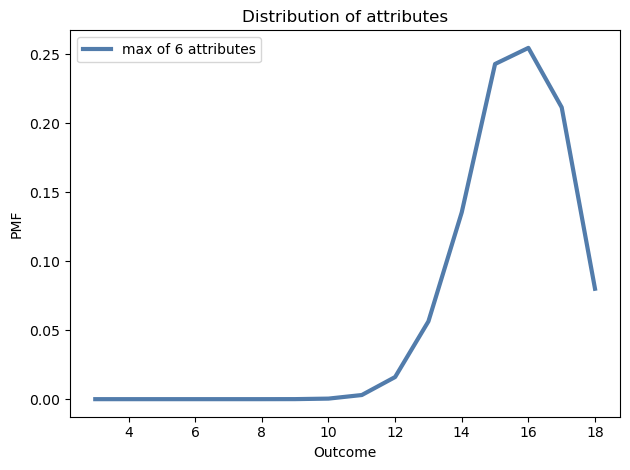

In [79]:
pmf_max6 = cdf_max6.make_pmf()

pmf_max6.plot(label='max of 6 attributes')
decorate_dice('Distribution of attributes')

<br>

### 구한 3개의 누적분포함수

In [80]:
import matplotlib.pyplot as plt

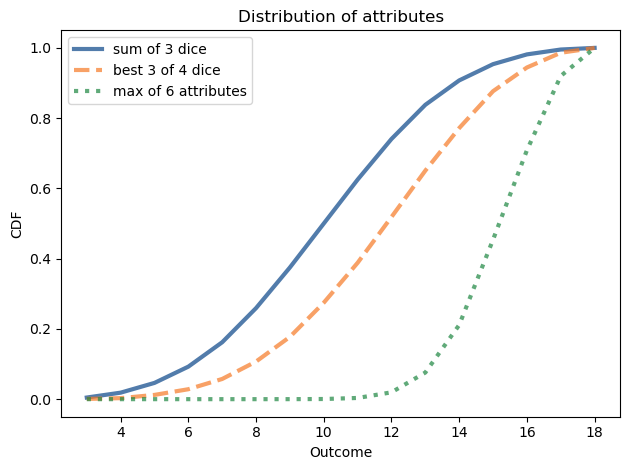

In [81]:
cdf_3d6 = pmf_3d6.make_cdf()
cdf_3d6.plot(label='sum of 3 dice')

cdf_best3 = pmf_best3.make_cdf()
cdf_best3.plot(label='best 3 of 4 dice', ls='--')

cdf_max6.plot(label='max of 6 attributes', ls=':')

decorate_dice('Distribution of attributes')
plt.ylabel('CDF');

<br>

## 07.04. 최솟값

<br>

**최솟값의 분포를 구하려면, 다음과 같이 구하는 상호보완 누적분포함수를 사용**
- **상호보완 누적분포함수 : $x$보다 큰 분포 상의 값에 대한 확률. 모든 6개의 값이 $x$를 초과할 확률**

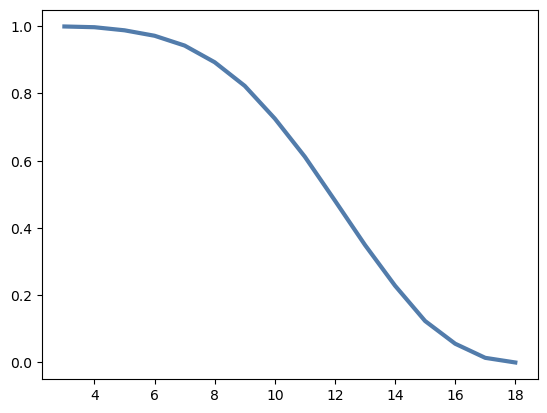

In [88]:
prob_gt = 1 - cdf_best3

prob_gt.plot()
plt.show()

<br>

**모든 6개의 값이 $x$를 초과할 확률**

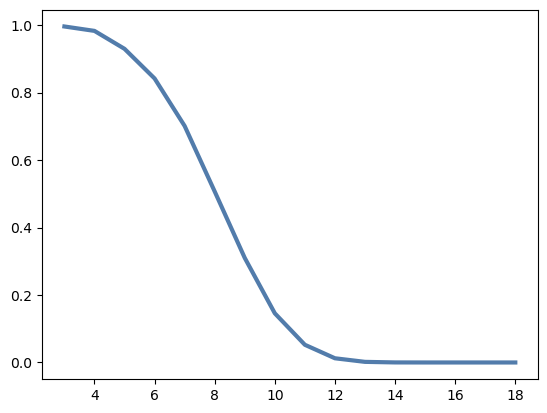

In [92]:
prob_gt6 = prob_gt**6

prob_gt6.plot()
plt.show()

<br>

**만약 6개의 값 모두 $x$를 초과한다면, 최소값 역시 $x$를 초과하므로, 최솟값의 상호보완 누적분포함수는**

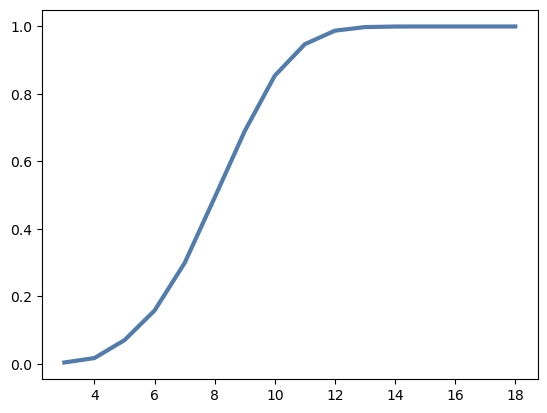

In [93]:
prob_le6 = 1 - prob_gt6
# Cdf(prob_le6)
# cdf_best3.min_dist(6)

prob_le6.plot()
plt.show()

<br>

### 6번의 시행의 최댓값/최솟값의 누적분포함수

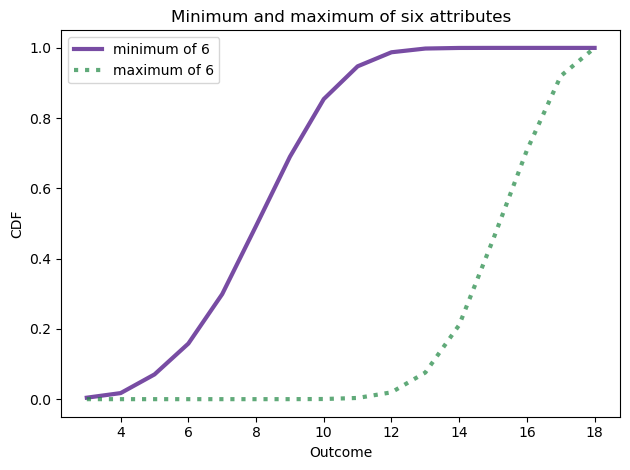

In [96]:
cdf_min6.plot(color='C4', label='minimum of 6')
cdf_max6.plot(color='C2', label='maximum of 6', ls=':')
decorate_dice('Minimum and maximum of six attributes')
plt.ylabel('CDF');

<br>

## 07.05. 혼합

> 게임 캐릭터의 능력치 설정에 있어
> 
> 하나의 능력치는 사면체 주사위를 한 번 굴려서 나온 결과만큼의 값 만큼 피해를 줌
>
> 하나의 능력치는 육면체 주사위를 한 번 굴린 결과만큼의 값 만큼 피해를 줌

In [102]:
d4 = make_die(4)
d6 = make_die(6)

1이 나올 확률은 각각 1/4, 1/6

각 능력치를 고를 확률은 1/2이므로, 총 확률은 둘의 평균

In [103]:
prob_1 = (d4(1) + d6(1)) / 2
prob_1

0.20833333333333331

**1 ~ 4가 나올 확률은 동일하지만, 5와 6의 경우는 사면체 주사위에서는 나올 수 없음**

In [104]:
prob_6 = (d4(6) + d6(6)) / 2
prob_6

0.08333333333333333


#### 혼합분포를 구하기 위해 가능한 결괏값에 대해 반복적으로 계산해서 확률을 계산

In [105]:
mix1 = (d4 + d6) / 2
mix1

,probs
1,0.208333
2,0.208333
3,0.208333
4,0.208333
5,0.083333
6,0.083333


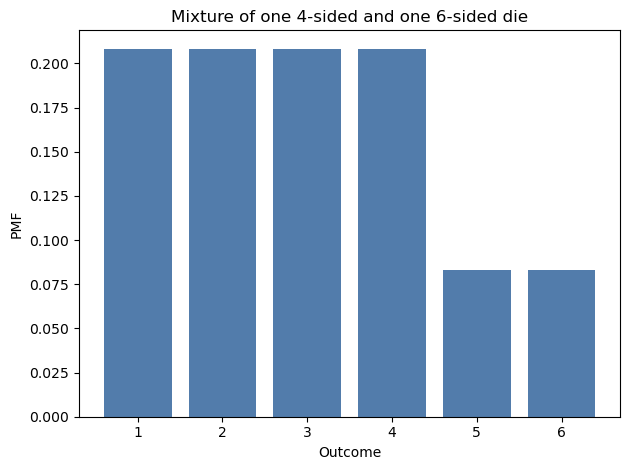

In [106]:
mix1.bar(alpha=0.7)
decorate_dice('Mixture of one 4-sided and one 6-sided die')

<br>

> 3명의 상대와의 전투에서
>
> 상대 중 하나는 사면체 주사위 하나의 결과에 따른 피해를 줌
>
> 상대 중 하나는 육면체 주사위 하나의 결과에 따른 피해를 줌
> 
> 나머지 상대는 육면체 주사위 하나의 결과에 따른 피해를 줌

<br>

**매 회마다 상대 중 하나에게 공격당하게 되있을 때, 상대가 주는 피해의 분포를 찾기 위해 가중평균을 계산**
- **1개의 사면체 주사위와, 2개의 육면체 주사위의 혼합분포**

In [112]:
mix2 = (d4 + 2*d6) / 3
mix2

,probs
1,0.194444
2,0.194444
3,0.194444
4,0.194444
5,0.111111
6,0.111111


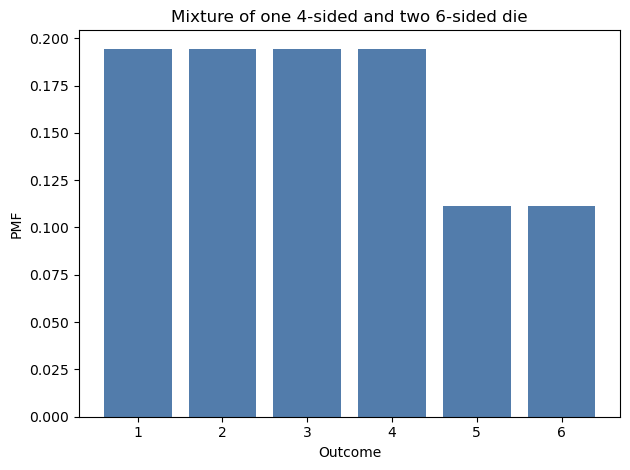

In [109]:
mix2.bar(alpha=0.7)
decorate_dice('Mixture of one 4-sided and two 6-sided die')

<br>

## 07.06. 일반적인 혼합

> 3명의 상대가 추가로 전투에 참여
> 
> 각 상대는 팔면체 주사위를 한 번 굴린 결과만큼의 피해를 줌

<br>

**여전히 매 회 마다 임의의 상대가 피해를 주기에, 상대에 의한 피해는 다음의 혼합**

- 1개의 사면체 주사위
- 2개의 육면체 주사위
- 3개의 팔면체 주사위

In [113]:
hypos = [4,6,8]
counts = [1,2,3]
pmf_dice = Pmf(counts, hypos)
pmf_dice

,probs
4,1
6,2
8,3


In [114]:
pmf_dice.normalize()
pmf_dice

,probs
4,0.166667
6,0.333333
8,0.500000


**위 분포는 주사위 종류와 각 주사위를 굴릴 확률을 표현 (= 주사위가 선택될 확률)**
- 6명의 상대중 팔면체의 주사위로 피해가 결정되는 상대가 공격할 확률은 3/6 = 0.5

<br>

**각 주사위 별 각 값이 나타날 확률**

In [121]:
dice = [make_die(sides) for sides in hypos]

# 4면체 주사위의 각 값별 확률
dice[0]

,probs
1,0.25
2,0.25
3,0.25
4,0.25


<br>

**혼합분포 계산을 위하여 주사위별 각 값이 나올 값을, 각 주사위가 선택될 확률을 가중치로 삼아 가중평균 계산**

In [122]:
import pandas as pd

In [130]:
df = pd.DataFrame(dice).fillna(0).transpose()
df

,,,
1,0.25,0.166667,0.125
2,0.25,0.166667,0.125
3,0.25,0.166667,0.125
4,0.25,0.166667,0.125
5,0.00,0.166667,0.125
6,0.00,0.166667,0.125
7,0.00,0.000000,0.125
8,0.00,0.000000,0.125


In [131]:
print(pmf_dice.ps)
df *= pmf_dice.ps
df

[0.16666667 0.33333333 0.5       ]


,,,
1,0.041667,0.055556,0.0625
2,0.041667,0.055556,0.0625
3,0.041667,0.055556,0.0625
4,0.041667,0.055556,0.0625
5,0.000000,0.055556,0.0625
6,0.000000,0.055556,0.0625
7,0.000000,0.000000,0.0625
8,0.000000,0.000000,0.0625


**행별 합계**

In [132]:
df.sum(axis=1)

1    0.159722
2    0.159722
3    0.159722
4    0.159722
5    0.118056
6    0.118056
7    0.062500
8    0.062500
dtype: float64

<br>

#### 위 과정을 하나로 모은 함수

In [133]:
def make_mixture(pmf, pmf_seq):
    
    """혼합분포 생성"""
    df = pd.DataFrame(pmf_seq).fillna(0).transpose()
    df *= np.array(pmf)
    total = df.sum(axis=1)
    
    return Pmf(total)

In [134]:
mix = make_mixture(pmf_dice, dice)

In [137]:
pmf_dice

,probs
4,0.166667
6,0.333333
8,0.500000


In [138]:
dice

[1    0.25
 2    0.25
 3    0.25
 4    0.25
 Name: , dtype: float64,
 1    0.166667
 2    0.166667
 3    0.166667
 4    0.166667
 5    0.166667
 6    0.166667
 Name: , dtype: float64,
 1    0.125
 2    0.125
 3    0.125
 4    0.125
 5    0.125
 6    0.125
 7    0.125
 8    0.125
 Name: , dtype: float64]

#### 매 회마다 상대로부터 받을 피해에 대한 확률분포

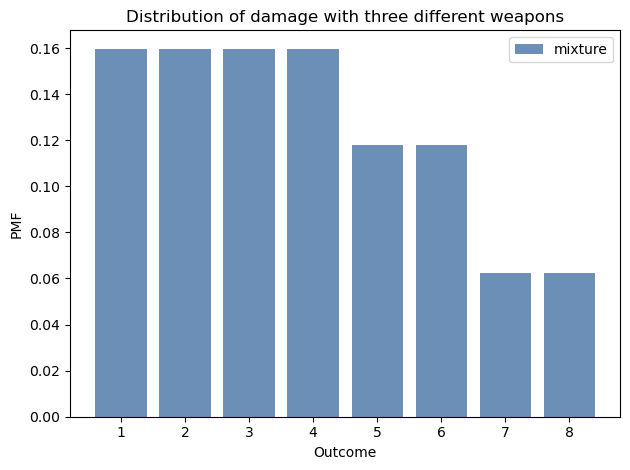

In [139]:
mix.bar(label='mixture', alpha=0.6)
decorate_dice('Distribution of damage with three different weapons')